In [1]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt 
import matplotlib
matplotlib.style.use("default")

In [2]:
batch_size = 128
img_shape = (28,28)

In [3]:
training_data = datasets.MNIST("./MNIST_DATA/", 
                               download= True, 
                               train = True,
                               transform= transforms.ToTensor(),
                              )
training_data.data = torch.unsqueeze(torch.true_divide(training_data.data, 255), 1)
training_data.targets = torch.clone(training_data.data)
training_data.data = training_data.data + torch.clamp(torch.rand((60000, 1, 28, 28)), 0, 0.8)

testing_data = datasets.MNIST("./MNIST_data/", 
                             download=True,
                              train = False, 
                              transform= transforms.ToTensor(),
                             )
testing_data.data = torch.unsqueeze(torch.true_divide(testing_data.data, 255), 1)
testing_data.targets = testing_data.data
testing_data.data = testing_data.data + torch.clamp(torch.rand((10000, 1, 28, 28)), 0, 0.8)

In [4]:
class Data(Dataset):
    def __init__(self, X, Y):
        self.data = X
        self.target = Y
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        target = self.target[idx]
        data = self.data[idx]
        return data, target
    
train_data = Data(training_data.data, training_data.targets)
test_data = Data(testing_data.data, testing_data.targets)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle = True)
test_loader = DataLoader(test_data, batch_size=batch_size)

In [5]:
def plot_sample(X, img_shape, sample_size = 10, n_rows = 2, n_columns = 5, seed = None):
    torch.manual_seed(seed)
    if sample_size != n_rows*n_columns:
        raise Exception("the argument sample_size should equal n_rows * n_columns")
    for i in range(sample_size):
        if i%(sample_size//2) == 0:
            figure = plt.figure(figsize=(15,15))
        ax = plt.subplot(n_rows, n_columns, i+1)
        idx = torch.randint(low = 0, high =len(X), size = (1,))
        plt.imshow(X[idx].view(*img_shape), cmap='gray')

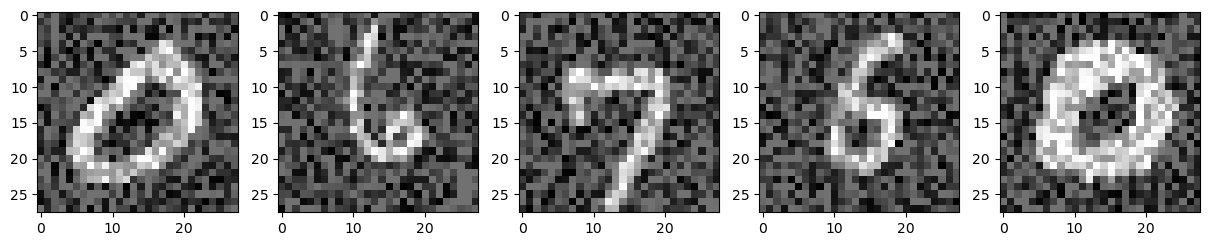

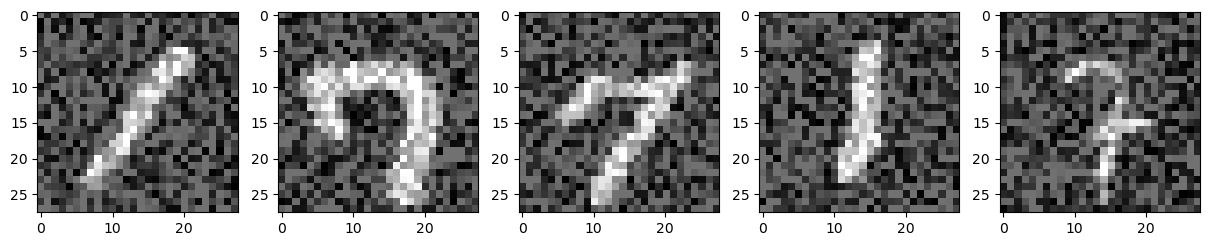

In [6]:
plot_sample(training_data.data, (28,28), seed= 45)

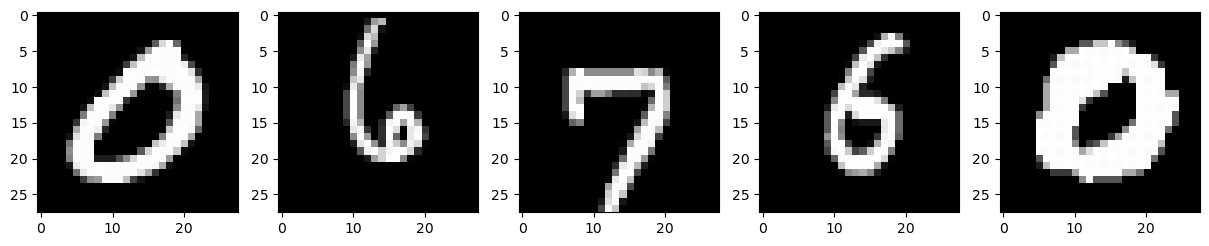

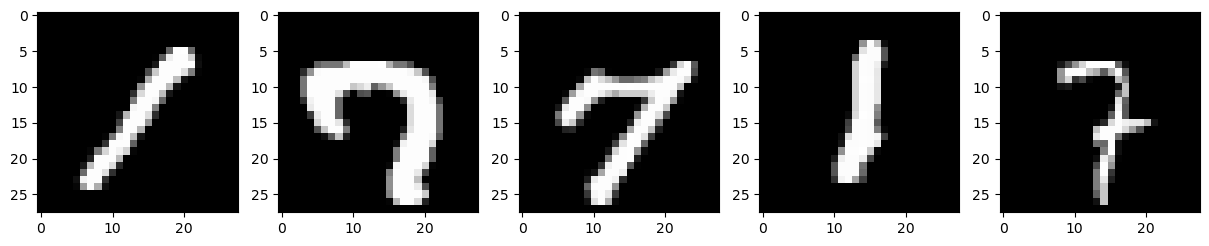

In [7]:
plot_sample(training_data.targets, (28,28), seed= 45)

In [8]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.enc_conv1 = nn.Conv2d(in_channels = 1, out_channels= 8, kernel_size=5)
        self.enc_conv2 = nn.Conv2d(in_channels = 8, out_channels= 16, kernel_size=5)
        self.enc_conv3 = nn.Conv2d(in_channels = 16, out_channels=32, kernel_size=5)
        self.enc_conv4 = nn.Conv2d(in_channels = 32, out_channels=64, kernel_size=5)
        self.enc_conv5 = nn.Conv2d(in_channels = 64, out_channels=128, kernel_size=5)
        self.dec_conv1 = nn.ConvTranspose2d(in_channels=128, out_channels= 64, kernel_size=5)
        self.dec_conv2 = nn.ConvTranspose2d(in_channels=64, out_channels= 32, kernel_size=5)        
        self.dec_conv3 = nn.ConvTranspose2d(in_channels=32, out_channels= 16, kernel_size=5)
        self.dec_conv4 = nn.ConvTranspose2d(in_channels=16, out_channels= 8, kernel_size=5)
        self.dec_conv5 = nn.ConvTranspose2d(in_channels=8, out_channels= 1, kernel_size=5)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        out = self.enc_conv1(x)
        out = self.relu(out)
        out = self.enc_conv2(out)
        out = self.relu(out)
        out = self.enc_conv3(out)
        out = self.relu(out)
        out = self.enc_conv4(out)
        out = self.relu(out)
        out = self.enc_conv5(out)
        out = self.relu(out)
        out = self.dec_conv1(out)
        out = self.relu(out)
        out = self.dec_conv2(out)
        out = self.relu(out)
        out = self.dec_conv3(out)
        out = self.relu(out)
        out = self.dec_conv4(out)
        out = self.relu(out)
        out = self.dec_conv5(out)
        out = self.sigmoid(out)
        return out

In [9]:
model = AutoEncoder()
CUDA = torch.cuda.is_available()
if CUDA:
    model = model.cuda()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)

In [10]:
epochs = 50
train_loss = [] 
test_loss = []
model = model.cuda()
for epoch in range(epochs):
    training_loss = 0.0
    testing_loss = 0.0 
    for batch, target in train_loader:
        if CUDA:
            batch = batch.cuda()
            target = target.cuda()
        out = model(batch)
        optimizer.zero_grad()
        loss = criterion(out, target)
        loss.backward()
        optimizer.step()
        training_loss += loss.item()
    train_loss.append(training_loss/target.size(0))
    test_loss = []
    for batch, target in test_loader:
        if CUDA:
            batch = batch.cuda()
            target = target.cuda()
        out = model(batch)
        loss = criterion(out, target)
        testing_loss += loss.item()
    test_loss.append(testing_loss/target.size(0))
    print(f"Epoch {epoch+1}/{epochs}, train_loss {train_loss[-1]}, test_loss {test_loss[-1]}")

Epoch 1/50, train_loss 0.39973461724972975, test_loss 0.23182803369127214
Epoch 2/50, train_loss 0.19526970223523676, test_loss 0.16687108960468322
Epoch 3/50, train_loss 0.15288294673276445, test_loss 0.14159292774274945
Epoch 4/50, train_loss 0.136655313661322, test_loss 0.1318776406114921
Epoch 5/50, train_loss 0.12772672922195247, test_loss 0.11843504186253995
Epoch 6/50, train_loss 0.11352486095468824, test_loss 0.10634371917694807
Epoch 7/50, train_loss 0.10515613436776523, test_loss 0.10116005211602896
Epoch 8/50, train_loss 0.10154599886542807, test_loss 0.10002310445997864
Epoch 9/50, train_loss 0.09943556397532423, test_loss 0.09701392659917474
Epoch 10/50, train_loss 0.09777174872579053, test_loss 0.09539320593466982
Epoch 11/50, train_loss 0.09566747294350837, test_loss 0.09337411192245781
Epoch 12/50, train_loss 0.09423276723828167, test_loss 0.09230826771818101
Epoch 13/50, train_loss 0.09310263339042042, test_loss 0.09125185431912541
Epoch 14/50, train_loss 0.09199347907

In [11]:
model = model.cpu()
test_correct = 0
test_total = 0 
Y_prediction = torch.tensor([])
for batch, labels in test_loader:
    result = model(batch)
    Y_prediction = torch.cat((Y_prediction, result))

In [13]:
def plot_sample(X, Y, img_shape):
    figure = plt.figure(figsize=(15,15))
    ax = plt.subplot(1, 2, 1)
    idx = torch.randint(low = 0, high =len(X), size = (1,))
    plt.imshow(X[idx].view(*img_shape), cmap='gray')
    ax = plt.subplot(1, 2, 2)
    plt.imshow(Y[idx].view(*img_shape), cmap='gray')

# After 20 Epochs 

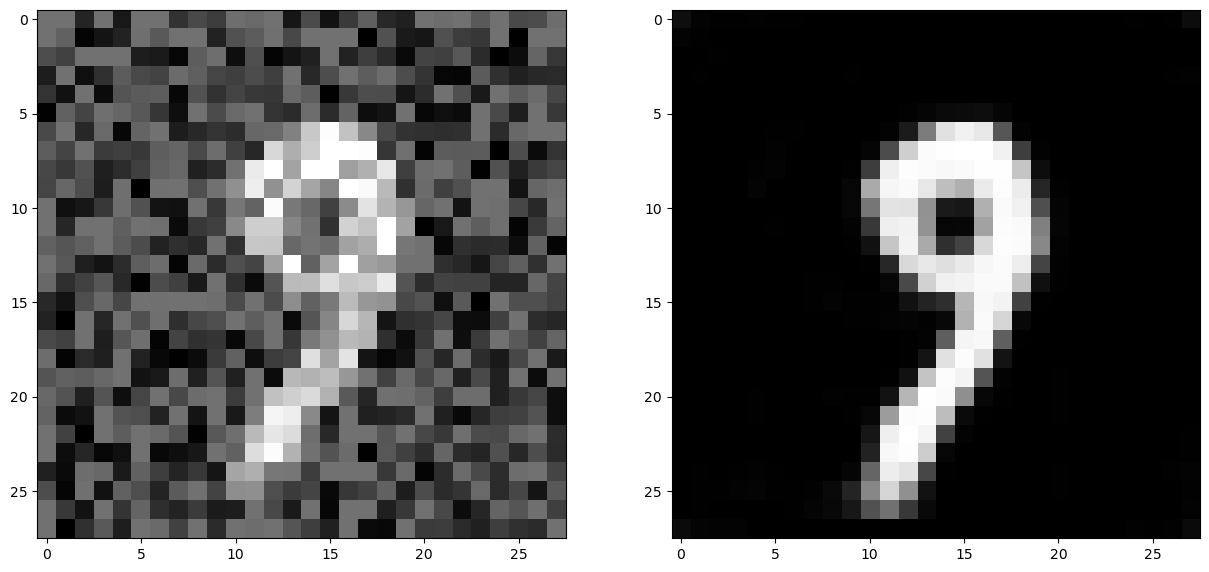

In [26]:
plot_sample(testing_data.data, Y_prediction.detach(), (28,28))

# After 50 Epochs

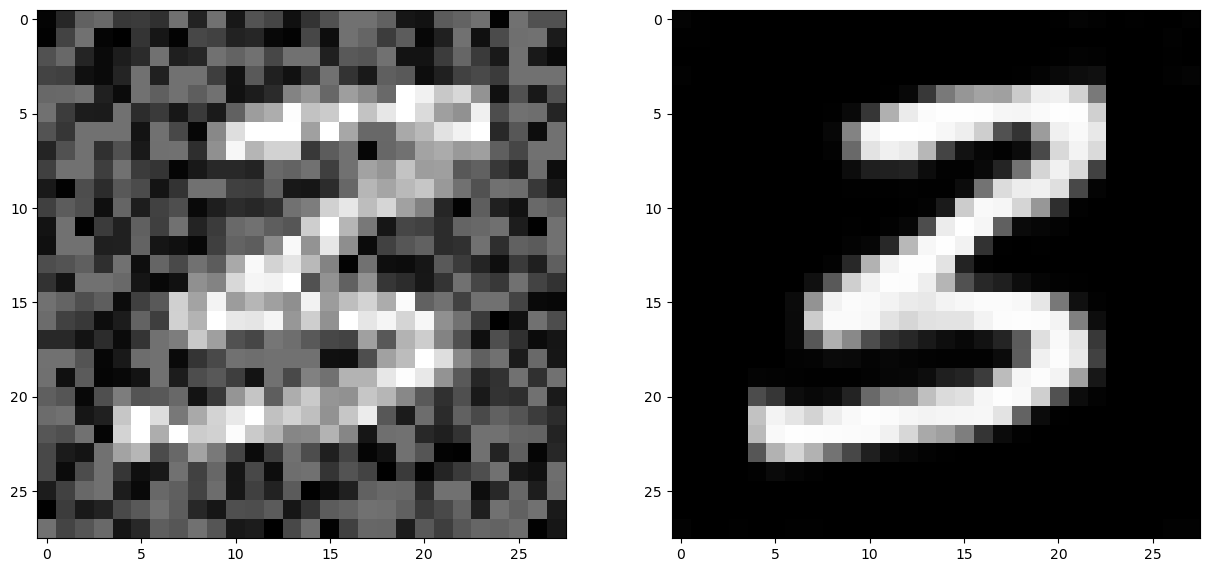

In [15]:
plot_sample(testing_data.data, Y_prediction.detach(), (28,28))

In [16]:
torch.save(model, "model.pt")